In [1]:
def hide_code_in_slideshow():   
    from IPython import display
    import binascii
    import os
    uid = binascii.hexlify(os.urandom(8)).decode()    
    html = """<div id="%s"></div>
    <script type="text/javascript">
        $(function(){
            var p = $("#%s");
            if (p.length==0) return;
            while (!p.hasClass("cell")) {
                p=p.parent();
                if (p.prop("tagName") =="body") return;
            }
            var cell = p;
            cell.find(".input").addClass("hide-in-slideshow")
        });
    </script>""" % (uid, uid)
    display.display_html(html, raw=True)

## Finding Malware in TLS with Machine Learning
- Presented by Bryan Scarbrough
- GSEC, GCIH, GCIA, GPYC, GXPN, GNFA, GCCC
- Master’s Degree Candidate at the SANS Technology Institute


---

### Import Modules and Data

- First stage of analysis is to import the required modules
- Create a function to import the data for processing
- Then print the dataset to verify successful import

---


In [5]:
%matplotlib inline

# Import some initial libraries to get started
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

# Set a random state variable for selection consistency
rand_state = 42

# Set malware label
label = 'malware_label'

# Function to import and format the dataset for processing
def get_data(sample_size, mal_percent=20, scaled=False):
    csv_data_file = r'./data/test_train_data.csv'
    full_dataset = pd.read_csv(csv_data_file)

    # Scale data to 0-1 value for more efficient ML analysis
    if scaled:
        mm_data = MinMaxScaler().fit_transform(full_dataset)
        full_dataset = pd.DataFrame(mm_data, columns=full_dataset.columns)

    # Convert label values to 1 and -1 (this is how OC-SVM performs predictions
    # so validation requires these values
    ben = 1
    mal = -1
    full_dataset.loc[full_dataset[label] == 1, label] = mal
    full_dataset.loc[full_dataset[label] == 0, label] = ben

    # Split dataset into benign and malware
    benign = full_dataset[full_dataset.malware_label == ben]
    malware = full_dataset[full_dataset.malware_label == mal]
    
    # Determine malware percentage of sample dataset size
    mal_size = int((mal_percent / 100) * sample_size)

    # Prevent malware sample size from being larger than actual sample size
    if mal_size > malware.shape[0]:
        mal_size = malware.shape[0]

    # Generate random sample of malware of size determined by mal_size variable
    malware = malware.sample(n=mal_size, random_state=rand_state)

    # Prevent total sample size from being larger than actual sample size
    total_sample_size = sample_size - mal_size
    if total_sample_size > benign.shape[0]:
        total_sample_size = benign.shape[0]

    # Now generate a benign data sample and combine the benign and malware samples
    # to a single returned dataset
    benign = benign.sample(n=total_sample_size, random_state=rand_state)
    sampled_data = benign.append(malware).reset_index(drop=True)
    sampled_data = sampled_data.sample(frac=1).reset_index(drop=True)

    # Return sample dataset
    return sampled_data

# Generate initial full dataset for analysis
full_dataset = get_data(117000)

# Drop rows with NaN (improperly calculated values rendered as Not-a-Number)
full_dataset = full_dataset.dropna()

# Print the dataset
print(full_dataset)

        dom_in_tranco_1m  dom_dga_prob  otx_status  otx_age  urlhaus_status  \
0                    0.0      0.000249           0      0.0             0.0   
1                    0.0      0.000301           0      0.0             0.0   
2                    0.0      0.000295           1    318.0             0.0   
3                    0.0      0.000578           0      0.0             0.0   
4                    0.0      0.001290           0      0.0             0.0   
...                  ...           ...         ...      ...             ...   
116907               0.0      0.000388           0      0.0             0.0   
116908               0.0      0.000199           0      0.0             0.0   
116909               0.0      0.000576           0      0.0             0.0   
116910               0.0      0.000262           0      0.0             0.0   
116911               0.0      0.000344           0      0.0             0.0   

        urlhaus_age  ja3_urlhaus_status  ja3_urlhau

---

## Data Analysis

Before conducting any ML processing it is:

  - Necessary to understand the nature of the data's relationships
  - Determine the significance of various data features and how they are related to one another

### Data Distribution

Below is the percent distribution of Malware to Benign data.

---

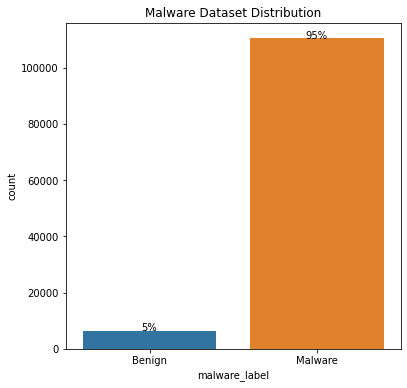

In [6]:
hide_code_in_slideshow()
# Column to analyze
target = full_dataset[label]
# Get dataset length for percentage calculation
total = len(full_dataset)
# Define graph area and title
plt.figure(figsize = (6, 6))
plt.title("Malware Dataset Distribution")

# Generate count plot and turn into bar graph for display
ax = sns.countplot(target)
for p in ax.patches:
    percentage = '{:.0f}%'.format(p.get_height() / total * 100)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 5
    ax.annotate(percentage, (x, y), ha = 'center')
    ax.set_xticklabels(['Benign', 'Malware'])

---

## Cipher Suite Analysis

- Time to analyze some of the individual features
- Begin with Cipher Suites (the metadata value with the largest number of features)
- The first graph shows the number of unique Cipher Suites used by each data classification (benign and malware)
- The bottom graphs represent the most used Cipher Suites sorted by classification
  - Left: Benign Cipher Suites used
  - Right: Malicious Cipher Suites used

---

In [7]:
# Separate dataset by malware label
mal = full_dataset[full_dataset.malware_label == -1]
ben = full_dataset[full_dataset.malware_label == 1]
    
def cipher_suites(mal, ben):
    # Select only Cipher Suite columns
    mal_cs_data = mal.filter(regex='cs_')
    ben_cs_data = ben.filter(regex='cs_')

    # Average Cipher Suite length value to graph in next cell
    mal_cs_size = round(mal_cs_data['cs_len'].sum() / len(mal_cs_data['cs_len']), 2)
    ben_cs_size = round(ben_cs_data['cs_len'].sum() / len(ben_cs_data['cs_len']), 2)

    # Drop Cipher Suite length field - not related to number of CS values offered by client
    mal_cs_data = mal_cs_data.drop(['cs_len'], axis=1)
    ben_cs_data = ben_cs_data.drop(['cs_len'], axis=1)

    # Drop columns containing only "0" values - these are CS values never offered by clients
    # Then determine the length of remaining values to determine number of CS values
    mal_cs_count = len(mal_cs_data.loc[:, (mal_cs_data != 0).any(axis=0)].columns)
    ben_cs_count = len(ben_cs_data.loc[:, (ben_cs_data != 0).any(axis=0)].columns)

    # Create graph container
    fig, axes = plt.subplots(2, 2, sharex=False, figsize=(15,12))

    # Calculate total number unique of Benign and Malware Cipher Suites used
    cs_count = pd.DataFrame({'Unique Cipher Suites': ['Benign Cipher Suites', 'Malware Cipher Suites'], 'Count': [ben_cs_count, mal_cs_count]})
    ax = sns.barplot(ax=axes[0,0], data=cs_count, y='Count', x='Unique Cipher Suites')
    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), ''),
                        (bar.get_x() + bar.get_width() / 2,  
                        bar.get_height()), ha='center', va='center', 
                        size=15, xytext=(0, 8), 
                        textcoords='offset points')

    # Sort cipher suites used by Benign importance
    ben_cs_sum = pd.DataFrame({"Benign": (ben_cs_data.sum() / len(ben_cs_data)), "Malware": (mal_cs_data.sum() / len(mal_cs_data))}, index=ben_cs_data.sum().sort_values().index).tail(20)
    ben_cs_sum.plot.barh(ax=axes[1,0], rot=0)
    axes[1,0].set_xlabel('Cipher Suites by Benign Importance')

    # Sorce cipher suites used by Malware importance
    mal_cs_sum = pd.DataFrame({"Benign": (ben_cs_data.sum() / len(ben_cs_data)), "Malware": (mal_cs_data.sum() / len(mal_cs_data))}, index=mal_cs_data.sum().sort_values().index).tail(20)
    mal_cs_sum.plot.barh(ax=axes[1,1], rot=0)
    axes[1,1].set_xlabel('Cipher Suites by Malware Importance')


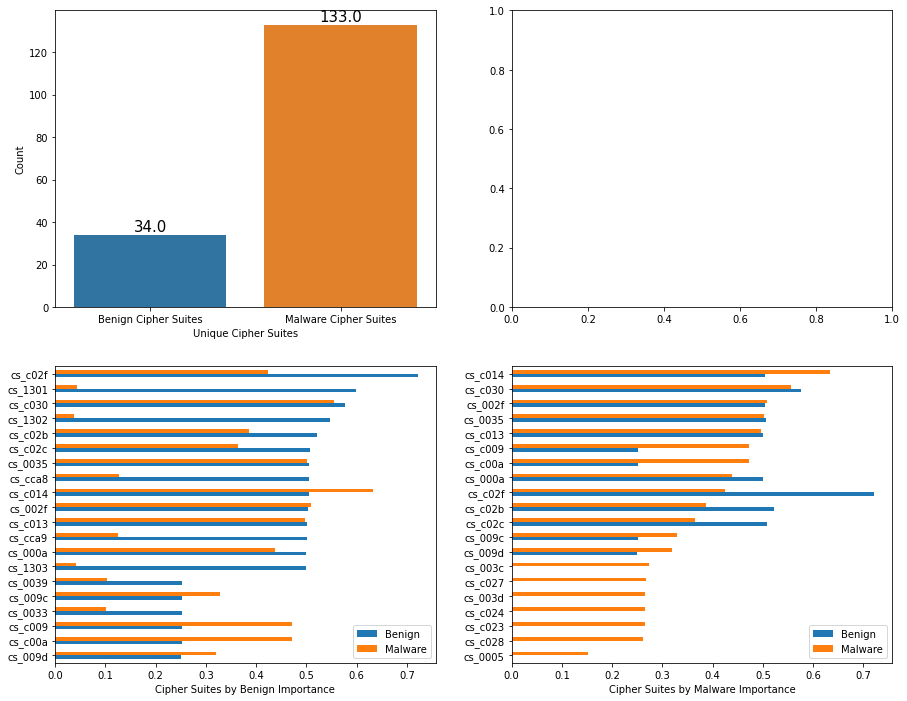

In [8]:
# Graph Cipher Suite relationships
cipher_suites(mal, ben)

---

## Port Analysis

- The next section of features worthy of analysis are the ports used

> NOTE: While these values are easily changeable by an attacker, they can also be overlooked, and for the purposes of this research offer enough variation to aid in ML analysis.

---

In [11]:
def ports(mal, ben):
    # PORT ANALYSIS
    #
    # Create dataframe of malicious and benign source and destination ports
    mal_prt = mal[['src_port', 'dst_port']]
    ben_prt = ben[['src_port', 'dst_port']]

    # Create graph container
    fig, axes = plt.subplots(3, 2, sharex=False, figsize=(15,15))

    # Calculate and graph number of unique destination ports
    ben_dst_percent = ben_prt.dst_port.unique().shape[0]
    mal_dst_percent = mal_prt.dst_port.unique().shape[0]
    dst_prt_sum = pd.DataFrame({'Unique Destination Ports': ['Benign Unique Dst Ports', 'Malware Unique Dst Ports'], 'Count': [ ben_dst_percent, mal_dst_percent]})
    ax = sns.barplot(ax=axes[0,0], data=dst_prt_sum, y='Count', x='Unique Destination Ports')
    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), ''),
                        (bar.get_x() + bar.get_width() / 2,  
                        bar.get_height()), ha='center', va='center', 
                        size=15, xytext=(0, 8), 
                        textcoords='offset points')

    # Calculate and graph number of unique source ports
    ben_src_percent = (ben_prt.src_port.unique().shape[0] / len(ben_prt.src_port)) * 100
    mal_src_percent = (mal_prt.src_port.unique().shape[0] / len(mal_prt.src_port)) * 100
    src_prt_sum = pd.DataFrame({'Unique Source Ports': ['Benign Unique Src Ports', 'Malware Unique Src Ports'], 'Count': [ ben_src_percent, mal_src_percent]})
    ax = sns.barplot(ax=axes[0,1], data=src_prt_sum, y='Count', x='Unique Source Ports')
    for bar in ax.patches:
        ax.annotate('{:.2f}%'.format(bar.get_height(), ''),
                        (bar.get_x() + bar.get_width() / 2,  
                        bar.get_height()), ha='center', va='center', 
                        size=15, xytext=(0, 8), 
                        textcoords='offset points')

    # Determine top benign destination ports
    ben_dst_prt = pd.DataFrame(ben_prt.dst_port.astype(int).value_counts().sort_values())
    ax = sns.barplot(ax=axes[1,0], data=dst_prt_sum, y=ben_dst_prt.dst_port, x=ben_dst_prt.index, orient='v')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set(xlabel='Benign Destionation Ports', ylabel='Count')

    # Determine top malware destination ports
    mal_dst_prt = pd.DataFrame(mal_prt.dst_port.astype(int).value_counts().sort_values()).tail(10)
    ax = sns.barplot(ax=axes[1,1], data=dst_prt_sum, y=mal_dst_prt.dst_port, x=mal_dst_prt.index, orient='v')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set(xlabel='Malware Destination Ports', ylabel='Count')

    # Determine top benign source ports
    ben_src_prt = pd.DataFrame(ben_prt.src_port.astype(int).value_counts()).head(10)
    ax = sns.barplot(ax=axes[2,0], data=src_prt_sum, y=ben_src_prt.src_port, x=ben_src_prt.index, orient='v')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set(xlabel='Benign Source Ports', ylabel='Count')

    # Determine top malware sourceports
    mal_src_prt = pd.DataFrame(mal_prt.src_port.astype(int).value_counts()).head(10)
    ax = sns.barplot(ax=axes[2,1], data=src_prt_sum, y=mal_src_prt.src_port, x=mal_src_prt.index, orient='v')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set(xlabel='Malware Source Ports', ylabel='Count')

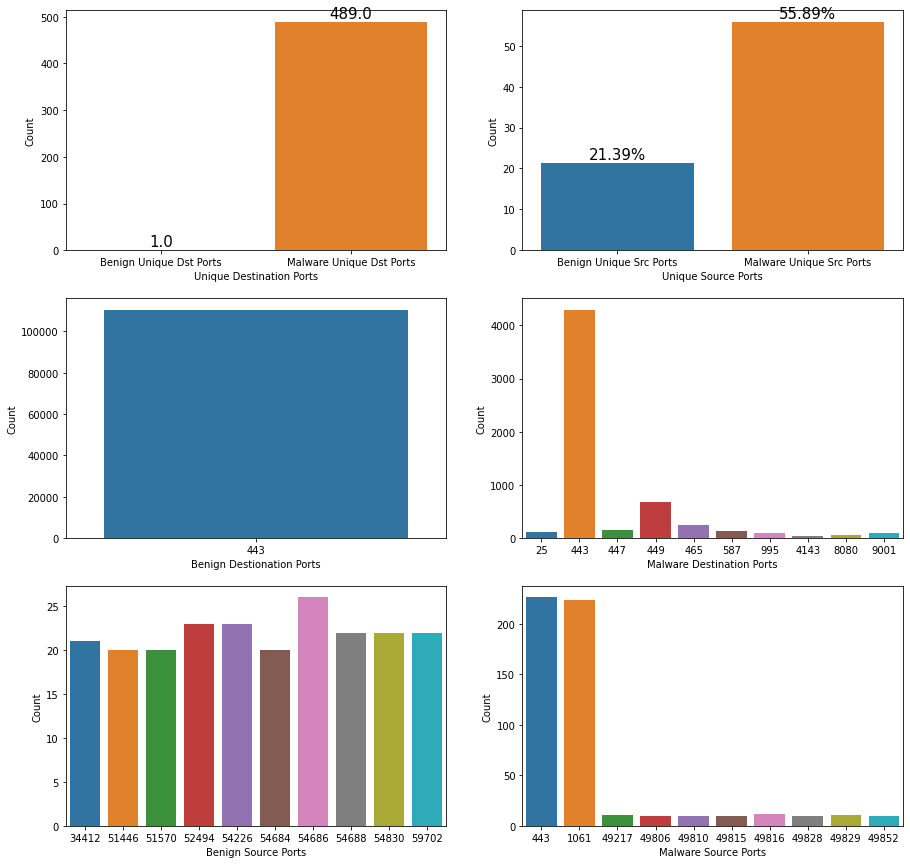

In [12]:
# Graph port relationships
ports(mal, ben)

---

### How a Support Vector Machine (SVM) Works...

- Binary classification system
- Calculates best line (or plane, also called hyperplane) to separate data
- Measures distance between nearest samples to hyperplane
  - Measurement determines the margin
  - Nearest samples called the Support Vectors
- When data is non-linear (cannot separate with straight line), SVM uses "kernels" to classify

<img src="./images/svm-margin.jpg" alt="Margin" style="width: 500px;" />

---

In [13]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
test_percent = 20

def graph_svm():
    # Import truncated dataset for expedited demonstration
    formatted_data = get_data(50000, 125, True)

    # Separate labels from feature data
    label_data = formatted_data.malware_label
    feature_data = formatted_data.drop(label, axis=1)

    # Perform PCA reduction to 2 components
    pca = PCA(n_components=2).fit_transform(feature_data)
    data = pd.DataFrame(pca)

    # Split data into test and training subsets
    svm_x_train, svm_x_test, svm_y_train, svm_x_test = train_test_split(data, label_data, test_size=(test_percent / 100), random_state=rand_state)

    # Train/Fit the SVM model
    svclassifier = SVC(kernel='rbf', C=1, gamma=0.1, probability=True, random_state=42)
    svclassifier.fit(svm_x_train, svm_y_train)
    x_data = np.array(data)

    # Generate the Margin graph
    plt.figure(figsize=(12,12))
    plt.scatter(x_data[:, 0], x_data[:, 1], c=label_data.values, s=40, cmap=plt.cm.winter, alpha=0.5)
    ax = plt.gca()
    xlim = [-2, 2]
    ylim = [-5, 4]
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    XX, YY = np.meshgrid(xx, yy)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = svclassifier.decision_function(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    ax.scatter(svclassifier.support_vectors_[:, 0], svclassifier.support_vectors_[:, 1],
                s=100, linewidth=1, facecolors='none', edgecolors='k')

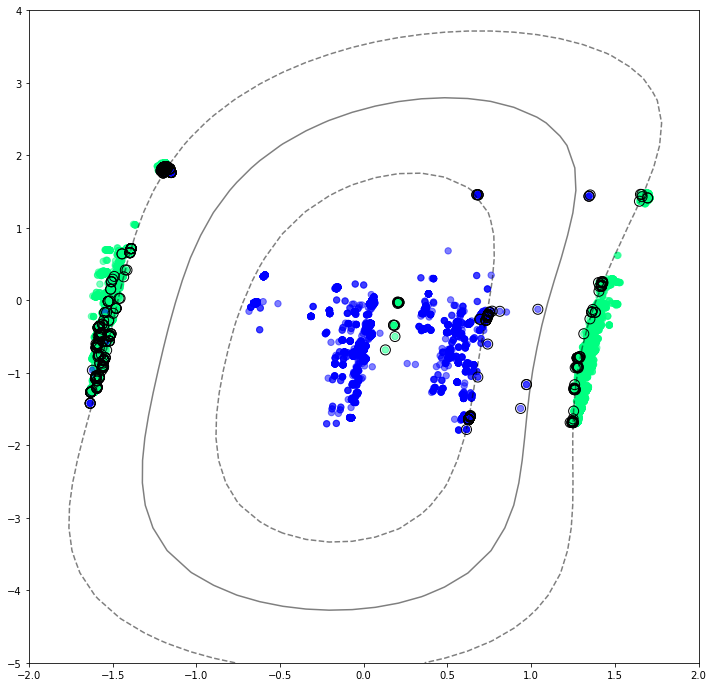

In [14]:
# Show the SVM Margin graph
graph_svm()

---

### The One-Class SVM

- Imbalanced datasets are an intrinsic problem with many ML algorithms such as the SVM
  - A significant imbalance between data classes makes ML model struggle to function
  - The SVM has problems calculating the margin
- One-Class SVM, or OC-SVM, solves this problem
  - Uses only the majority class to designate the decision boundary
  - Treats anything outside the boundary as an anomaly

<img src="./images/oc-svm-margin.png" alt="Margin" style="width: 420px;display: inline-block;" /><img src="./images/oc-svm-classification.png" alt="Classification" style="width: 420px;display: inline-block;" />

---

In [15]:
from sklearn.svm import OneClassSVM

# Generate new random dataset
formatted_data = get_data(50000, 0.2, True)

# Split dataset by label - the OC-SVM is trained with Benign data ONLY
oc_benign = formatted_data[formatted_data.malware_label == 1]
oc_malware = formatted_data[formatted_data.malware_label == -1]

# Split dataset into test and training 
oc_b_train, oc_b_test = train_test_split(oc_benign, test_size=(test_percent / 100), random_state=rand_state)
oc_b_train = oc_b_train.drop(label, axis=1)

# Set nu and gamma hyperparameters (nu is expected percentage of malware in dataset)
nu_value = (len(oc_malware) / len(oc_b_test))
gamma_val = 0.1

# Combine malware with test sample for analysis
oc_test = oc_b_test.append(oc_malware)
oc_test_label = oc_test.malware_label
oc_test = oc_test.drop(label, axis=1)

# Train/Fit OC-SVM data model
svclassifier = OneClassSVM(nu=nu_value, kernel='rbf', gamma=gamma_val)
svclassifier.fit(oc_b_train)

OneClassSVM(gamma=0.1, nu=0.01002004008016032)


### OC-SVM Scores

- Calculate how the OC-SVM performs (not speed, but correctness)
- Scores used:
  - Accuracy
  - Precision
  - Recall
  - F2 Score

<img src="./images/precision-recall-relevance.png" alt="Precision-Recall" style="width: 800px;" />

---

In [16]:
from sklearn.model_selection import cross_val_score

# Calculate F-scores
def f_beta(beta, precision, recall):
    return (beta*beta + 1) * precision * recall / (beta * beta * precision + recall)

# Perform n-fold cross validation and calculate the mean score across the cv=## folds
print('\nCalculating OC-SVM scores...')
for val in ['accuracy', 'precision', 'recall']:
    score = cross_val_score(svclassifier, oc_test, oc_test_label, cv=5, scoring=val).mean()
    print("{}: {}".format(val, score))
    if val == 'precision':
        prec = score
    elif val == 'recall':
        rec = score
print("F2 Score: {}".format(f_beta(2.0, prec, rec)))



Calculating OC-SVM scores...
accuracy: 0.9928571428571429
precision: 1.0
recall: 0.992691453756172
F2 Score: 0.9941446041186226


---

### OC-SVM Performance Graphs

- Finally, visualize OC-SVM performance
- Left graph is Confusion Matrix showing
  - True-Positive
  - True-Negative
  - False-Positive
  - False-Negative
- Right graph is Receiver Operating Characteristic (ROC) Curve
  - Represents F1 score of model
  - Everything "inside" or "below" the orange line is correctly classified

---

In [17]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

def graph_oc_svm():
    oc_pred = svclassifier.predict(oc_test)
    ben = 0
    mal = 1
    oc_pred[oc_pred == 1] = 0
    oc_pred[oc_pred == -1] = 1

    oc_test_label[oc_test_label == 1] = 0
    oc_test_label[oc_test_label == -1] = 1

    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,8))

    # Generate AUC graph
    fpr, tpr, _ = roc_curve(oc_test_label, oc_pred)
    auc = roc_auc_score(oc_test_label, oc_pred)
    plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(fpr, tpr, label='ROC Curve (area = {})'.format(str(auc)), color='darkorange')
    plt.legend(loc='lower right')
    plt.title('Receiver Operating Characteristic (ROC curve)')

    # Generate Confusion Matrix
    conf_matrix = confusion_matrix(oc_test_label, oc_pred)
    sns.heatmap(conf_matrix, ax=ax1,
            xticklabels=['Benign', 'Malware'],
            yticklabels=['Benign', 'Malware'],
            annot=True, fmt='d')

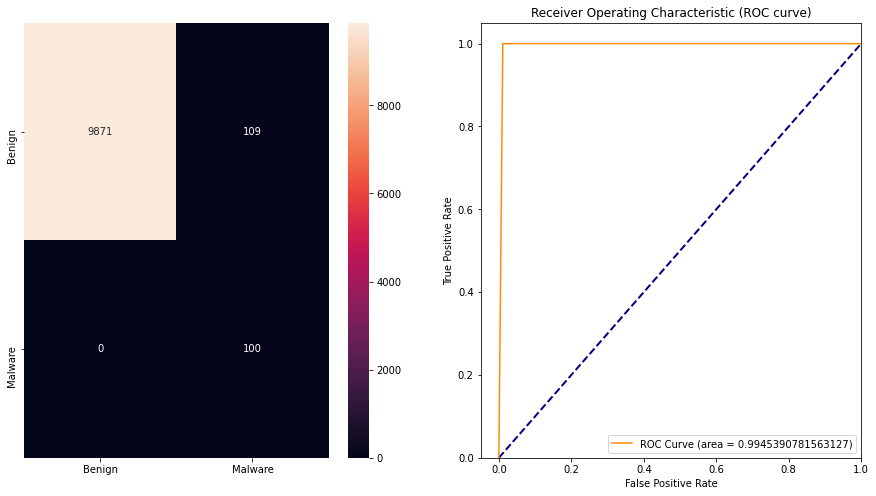

In [18]:
# Generate the Confusion Matrix and ROC graph
graph_oc_svm()